In [1]:
import os
import sys
import copy
import multiprocessing
import functools
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import util
import util_figures
import util_stimuli
import util_cochlea

sys.path.append('bez2018model')
import bez2018model


def vector_strength(spikes, t_spikes, frequency):
    """
    Args
    ----
    spikes (np.ndarray): timeseries of spike counts
    t_spikes (np.ndarray): timestamps for `spikes`
    frequency (float): stimulus frequency in Hz
    
    Returns
    -------
    vs (float): vector strength between 0 and 1
        quantifying periodicity in the spikes
    """
    phase = 2 * np.pi * t_spikes * frequency
    x = np.sum(spikes * np.cos(phase))
    y = np.sum(spikes * np.sin(phase))
    vs = np.sqrt(np.square(x) + np.square(y)) / np.sum(spikes)
    return vs


2024-03-10 20:08:37.590643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 20:08:39.212199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dur = 0.150
sr = 32e3
t = np.arange(0, dur, 1 / sr)
kwargs_nervegram = {
    'nervegram_dur': dur - 0.1,
    'nervegram_dtype': 'float16',
    'nervegram_fs': 20e3,
    'buffer_end_dur': 0.01,
    'buffer_start_dur': 0.07,
    'pin_fs': 100e3,
    'pin_dBSPL_flag': 0,
    'pin_dBSPL': None,
    'species': 2,
    'bandwidth_scale_factor': 1.0,
    'cf_list': None,
    'num_cf': 50,
    'min_cf': 125,
    'max_cf': 8e3,
    'max_spikes_per_train': 1000,
    'num_spike_trains': 100,
    'cohc': 1.0,
    'cihc': 1.0,
    'IhcLowPass_cutoff': 3000,
    'IhcLowPass_order': 7,
    'spont': [70.0, 4.0, 0.1],
    'noiseType': 1,
    'implnt': 0,
    'tabs': 6e-4,
    'trel': 6e-4,
    'synapseMode': 0,
    'random_seed': None,
    'return_vihcs': False,
    'return_meanrates': True,
    'return_spike_times': False,
    'return_spike_tensor_sparse': False,
    'return_spike_tensor_dense': True,
    'nervegram_spike_tensor_fs': 20e3,
    'squeeze_spont_dim': True,
    'squeeze_channel_dim': True,
}


def spike_counts_binomial_approx(rate, sr, num_spike_trains=1000):
    """
    """
    p = rate / sr
    q = 1 - p
    n = np.array([num_spike_trains] * p.shape[1]).reshape([1, p.shape[1]])
    spike_counts = np.random.normal(
        loc=n * p,
        scale=np.sqrt(n * p * q),
        size=None)
    spike_counts[spike_counts < 0] = 0
    spike_counts = np.round(spike_counts)
    return spike_counts


def spike_counts_binomial(rate, sr, num_spike_trains=100):
    """
    """
    p = rate / sr
    n = np.array([num_spike_trains] * p.shape[1]).reshape([1, p.shape[1]])
    spike_counts = np.random.binomial(n, p, size=None)
    return spike_counts


def get_bez2018model_pure_tone_response(f, IhcLowPass_cutoff=3000):
    """
    """
    y = np.sin(2 * np.pi * f * t)
    y = util_stimuli.set_dBSPL(y, 60.0)
    kwargs_nervegram_f = copy.deepcopy(kwargs_nervegram)
    kwargs_nervegram_f['cf_list'] = [max(f, 125)]
    kwargs_nervegram_f['IhcLowPass_cutoff'] = IhcLowPass_cutoff
    out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram_f)
    nervegram_meanrates = out_dict['nervegram_meanrates']
    nervegram_spike_tensor = out_dict['nervegram_spike_tensor_dense']
    nervegram_sr = out_dict['nervegram_fs']
    to_return = {
        'f': np.array(f),
        't': np.arange(0, nervegram_meanrates.shape[1]) / nervegram_sr,
        'sr': np.array(nervegram_sr),
        'rate': nervegram_meanrates[0],
        'spike_counts': np.sum(nervegram_spike_tensor, axis=(0, 1)),
        'num_spike_trains': np.array(kwargs_nervegram_f['num_spike_trains']),
    }
    to_return['spike_counts_binomial'] = spike_counts_binomial(
        to_return['rate'],
        sr=to_return['sr'],
        num_spike_trains=to_return['num_spike_trains'])
    to_return['spike_counts_binomial_approx'] = spike_counts_binomial_approx(
        to_return['rate'],
        sr=to_return['sr'],
        num_spike_trains=to_return['num_spike_trains'])
    return to_return

with multiprocessing.Pool(32) as pool:
    dict_out = {}
    for IhcLowPass_cutoff in [3000, 1000, 320, 50]:
        np.random.seed(0)
        list_freq = np.exp(np.arange(np.log(62.5), np.log(8e3) + 1e-12, np.log(2) / 24))
        f = functools.partial(get_bez2018model_pure_tone_response, IhcLowPass_cutoff=IhcLowPass_cutoff)
        list_out = pool.map(f, list_freq)
        tag_model = 'bez2018model_ihc{:04.0f}'.format(IhcLowPass_cutoff)
        dict_out[tag_model] = list_out
        print(tag_model, len(list_out))


bez2018model_ihc3000 169
bez2018model_ihc1000 169
bez2018model_ihc0320 169
bez2018model_ihc0050 169


In [5]:
list_data = []
for tag_model in dict_out.keys():
    list_out = dict_out[tag_model]
    for freq, out in zip(list_freq, list_out):
        list_key_spike_counts = [k for k in out.keys() if 'spike_counts' in k]
        data = {'tag_model': tag_model, 'f': freq}
        for key in list_key_spike_counts:
            list_spont = ['HSR', 'MSR', 'LSR']
            for itr_spont, spont in enumerate(list_spont):
                key_data = f'{key.replace("spike_counts", "vs")}_{spont}'
                data[key_data] = vector_strength(out[key][:, itr_spont], out['t'], freq)
        list_data.append(data)
df_bez2018model = pd.DataFrame(list_data)


/tmp/ipykernel_37441/2273232740.py:43: RuntimeWarning: invalid value encountered in scalar divide
  vs = np.sqrt(np.square(x) + np.square(y)) / np.sum(spikes)


In [6]:
df_animal = pd.read_csv('data/misc/palmer_russel_1986_fig5_auto_extract.csv', header=None, names=['f', 'vs'])
df_animal['f'] = 1e3 * df_animal['f']
df_animal['tag_model'] = 'palmer_russel_1986'
df_animal['vs_HSR'] = df_animal['vs']
df_animal['vs_binomial_approx_HSR'] = df_animal['vs']
df_animal['vs_binomial_HSR'] = df_animal['vs']
len(df_animal)


195

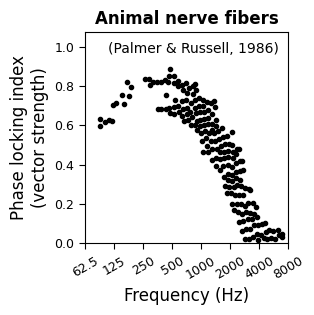

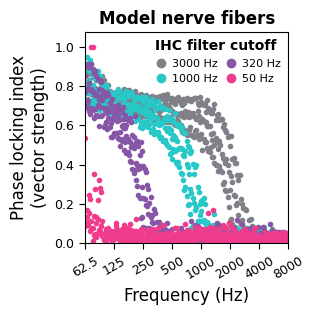

In [7]:
for itr, df_to_plot in enumerate([df_animal, df_bez2018model]):
    fig, ax = plt.subplots(figsize=(3.25, 3.25))
    list_spont = [
        'HSR',
        'MSR',
        'LSR',
    ]
    vs_key = 'vs_binomial_approx'
    for tag_model in np.unique(df_to_plot.tag_model.values)[::-1]:
        if 1:
            color, label = util.get_color_and_label_from_model_tag(tag_model)
            if 'Hz IHC filter' in label:
                str_title = 'Model nerve fibers'
                label = label.replace('Hz IHC filter', 'Hz')
            if 'palmer' in tag_model:
                str_title = 'Animal nerve fibers'
                label = None
                color = 'k'
                ax.text(
                    8e3,
                    1.025,
                    '(Palmer & Russell, 1986)  ',
                    va='top',
                    ha='right',
                    fontsize=10,
                )
            dfp = df_to_plot[np.logical_and.reduce([
                df_to_plot.tag_model == tag_model,
            ])]
            for spont in list_spont:
                x = dfp.f.values
                if f'{vs_key}_{spont}' in dfp.columns:
                    y = dfp[f'{vs_key}_{spont}'].values
                    ax.plot(x, y, ls='', marker='.', color=color, label=label if spont == 'HSR' else None)
    xticks = [62.5, 125, 250, 500, 1000, 2000, 4000, 8000]
    xticklabels = xticks
    util_figures.format_axes(
        ax,
        str_xlabel='Frequency (Hz)',
        str_ylabel='Phase locking index\n(vector strength)',
        str_title=str_title,
        fontweight_title='bold',
        xscale='log',
        yscale='linear',
        fontsize_ticks=9,
        fontsize_labels=12,
        ylimits=[0, 1.075],
        yticks=np.arange(0, 1.01, 0.2),
        xticks=xticks,
        xticklabels=xticklabels,
        xlimits=[62.5, 8e3]
    )
    ax.set_xticklabels(xticklabels, rotation=30)
    ax.minorticks_off()
    if itr > 0:
        ax.legend(
            frameon=False,
            framealpha=1,
            edgecolor='k',
            handletextpad=0,
            borderaxespad=0.2,
            markerscale=2,
            fontsize=8,
            ncol=2,
            columnspacing=0.2,
            loc='upper right',
            title='IHC filter cutoff',
            title_fontproperties={'size': 10, 'weight': 'bold'})
    ax.set_facecolor('w')
    fig.patch.set_color('none')
    plt.tight_layout()
    plt.show()


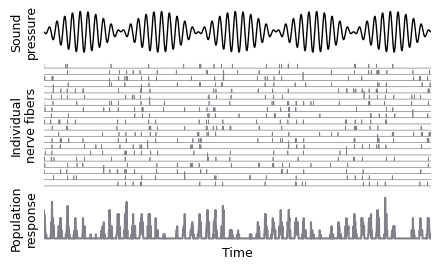

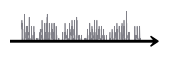

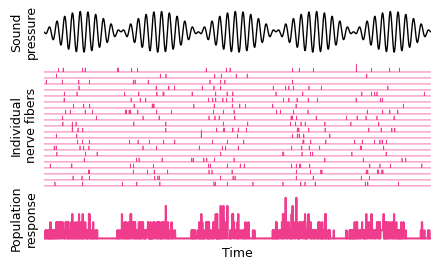

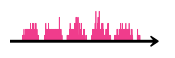

In [9]:
np.random.seed(998)

sr = 20e3
dur = 0.150
t = np.arange(0, dur, 1/sr)
f = 640
y = np.sin(2 * np.pi * f * t)
f_env = 32
y_env = np.cos(2 * np.pi * f_env * t)
y = y * y_env
y = util_stimuli.set_dBSPL(y, 30)

for IhcLowPass_cutoff in [3e3, 320.0]:
    kwargs_nervegram_tmp = copy.deepcopy(kwargs_nervegram)
    kwargs_nervegram_tmp['cf_list'] = [f]
    kwargs_nervegram_tmp['nervegram_dur'] = 2.5 / f_env
    kwargs_nervegram_tmp['buffer_start_dur'] = dur - (2.5/f_env) - (1/sr) - 0.0015
    kwargs_nervegram_tmp['buffer_end_dur'] = 0.0 + 0.0015
    kwargs_nervegram_tmp['IhcLowPass_cutoff'] = IhcLowPass_cutoff
    kwargs_nervegram_tmp['spont'] = [4.0]
    kwargs_nervegram_tmp['num_spike_trains'] = 384
    out_dict = bez2018model.nervegram(y, sr, **kwargs_nervegram_tmp)
    signal = out_dict['signal']
    t_signal = np.arange(0, signal.shape[-1]) / out_dict['signal_fs']
    spikes = out_dict['nervegram_spike_tensor_dense'][:, 0, :, 0]
    t_spikes = np.arange(0, spikes.shape[-1]) / out_dict['nervegram_spike_tensor_fs']
    color, label = util.get_color_and_label_from_model_tag('IHC3000' if IhcLowPass_cutoff > 1e3 else 'IHC0050')
    fig, ax_arr = plt.subplots(
        figsize=(5, 3),
        nrows=3,
        ncols=1,
        gridspec_kw={'height_ratios': [1, 3, 1], 'hspace': 0.05},
    )
    ax_arr[0].plot(t_signal, signal, lw=1, color='k')
    n_per_line = 384 // 48
    for itr0 in range(20):
        IDX = slice(n_per_line * itr0, n_per_line * itr0 + n_per_line)
        ax_arr[1].plot(t_spikes, spikes[IDX].sum(axis=0) + itr0*1.5, lw=0.5, color=color)
    ax_arr[2].plot(t_spikes, spikes.sum(axis=0), lw=1.5, color=color)
    for itr_ax, ax in enumerate(ax_arr):
        util_figures.format_axes(
            ax,
            xticklabels=[],
            yticklabels=[],
            xticks=[],
            yticks=[],
            xlimits=[t_spikes[0], t_spikes[-1]],
            spines_to_hide=['left', 'right', 'top', 'bottom'])
        fontsize = 9
        fontweight = None
        rotation = 90
        if itr_ax == 0:
            ax.set_ylabel('Sound\npressure', fontsize=fontsize, fontweight=fontweight, rotation=rotation)
        elif itr_ax == 1:
            ax.set_ylabel('Individual\nnerve fibers', fontsize=fontsize, fontweight=fontweight, rotation=rotation)
        elif itr_ax == 2:
            ax.set_ylabel('Population\nresponse', fontsize=fontsize, fontweight=fontweight, rotation=rotation)
            ax.set_xlabel('Time', fontsize=fontsize, fontweight=fontweight)
    plt.show()


    fig, ax = plt.subplots(figsize=(2, 0.5))
    ax.plot(t_spikes, spikes.sum(axis=0), lw=0.5, color=color, zorder=-1)
    x = -t_spikes[-1] / 10
    dx = x + 1.35 * t_spikes[-1]
    ax.arrow(
        x=x,
        y=0,
        dx=dx,
        dy=0,
        length_includes_head=True,
        width=spikes.sum(axis=0).max()/20,
        head_width=spikes.sum(axis=0).max()/3,
        head_length=0.005,
        overhang=0.5,
        color='k')
    util_figures.format_axes(
        ax,
        xticklabels=[],
        yticklabels=[],
        xticks=[],
        yticks=[],
        xlimits=[x, (x + dx) * 1.05],
        spines_to_hide=['left', 'right', 'top', 'bottom'])
    plt.show()


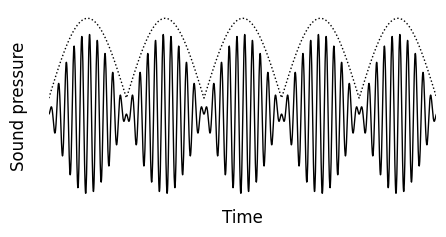

In [10]:
fig, ax = plt.subplots(figsize=(5, 2.5))

t = t_signal
y_tfs = np.sin(2 * np.pi * f * t)
y_env = np.sin(2 * np.pi * f_env * t)
ax.plot(t, y_tfs * y_env, color='k', lw=1)
ax.plot(t, np.abs(y_env) + 0.2, color='k', ls=':', lw=1)
util_figures.format_axes(
    ax,
    xticklabels=[],
    yticklabels=[],
    xticks=[],
    yticks=[],
    xlimits=[t[0], t[-1]],
    spines_to_hide=['left', 'right', 'top', 'bottom'])
ax.set_xlabel('Time', rotation=0, labelpad=5, fontsize=12)
ax.set_ylabel('Sound pressure', labelpad=15, fontsize=12)
plt.show()


In [13]:
dur = 0.150
sr = 32e3
t = np.arange(0, dur, 1/sr).astype(np.float32)

np.random.seed(0)
list_freq = np.exp(np.arange(np.log(62.5), np.log(8e3) + 1e-12, np.log(2) / 24))
y = np.sin(2 * np.pi * list_freq[:, np.newaxis] * t[np.newaxis, :])
y = util_stimuli.set_dBSPL(y, 60.0)

kwargs_cochlea = {
    "config_filterbank": {
        "cfs": None,
        "fir_dur": 0.05,
        "kwargs_filter_coefs": {},
        "max_cf": 14000.0,
        "min_cf": 60.0,
        "mode": "fir_gammatone_filterbank",
        "num_cf": 100
    },
    "config_subband_processing": {
        "rectify": True
    },
    "kwargs_custom_slice": {
        "args": [
            1600,
            2600
        ],
        "axis": 2
    },
    "kwargs_fir_lowpass_filter_input": {},
    "kwargs_fir_lowpass_filter_output": {
        "cutoff": 3000,
        "fir_dur": 0.05,
        "ihc_filter": True,
        "order": 7
    },
    "kwargs_sigmoid_rate_level_function": {
        "dynamic_range": [
            20.0,
            40.0,
            80.0
        ],
        "dynamic_range_interval": 0.95,
        "envelope_mode": True,
        "rate_max": [
            250.0,
            250.0,
            250.0
        ],
        "rate_spont": [
            0.0,
            0.0,
            0.0
        ],
        "threshold": [
            0.0,
            12.0,
            28.0
        ]
    },
    "kwargs_spike_generator_binomial": {
        "mode": "approx",
        "n_per_channel": [
            192,
            80,
            48
        ]
    },
    "kwargs_spike_rate_noise": {},
    "sr_cochlea": 32000.0,
    "sr_input": 32000.0,
    "sr_output": 20000.0
}

kwargs_cochlea['config_filterbank']['cfs'] = list_freq
kwargs_cochlea['config_filterbank']['min_cf'] = None
kwargs_cochlea['config_filterbank']['max_cf'] = None
kwargs_cochlea['config_filterbank']['num_cf'] = None
kwargs_cochlea['kwargs_sigmoid_rate_level_function']['rate_spont'] = 0
kwargs_cochlea['kwargs_spike_generator_binomial']['n_per_channel'] = [1000, 1000, 1000]
kwargs_cochlea['kwargs_spike_generator_binomial']['mode'] = 'approx'

dict_out = {}
for IhcLowPass_cutoff in [3000, 1000, 320, 50]:
    kwargs_cochlea_tmp = copy.deepcopy(kwargs_cochlea)
    kwargs_cochlea_tmp['kwargs_fir_lowpass_filter_output']['cutoff'] = IhcLowPass_cutoff
    tensor_input = tf.keras.Input(
        shape=t.shape,
        batch_size=None,
        dtype=tf.dtypes.float32)
    _, model = util_cochlea.cochlea(
        tensor_input,
        **kwargs_cochlea_tmp)
    model_out = model(y).numpy()
    tag_model = 'simplified_ihc{:04.0f}'.format(IhcLowPass_cutoff)
    dict_out[tag_model] = model_out
    print(tag_model, model_out.shape, kwargs_cochlea_tmp['kwargs_fir_lowpass_filter_output']['cutoff'])


2024-03-10 20:16:31.269835: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11412 MB memory:  -> device: 0, name: TITAN Xp, pci bus id: 0000:05:00.0, compute capability: 6.1


[cochlea] converting audio to subbands using fir_gammatone_filterbank
[cochlea] half-wave rectified subbands
[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=169, time=4800]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'cutoff': 3000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[fir_lowpass_filter] sr_filt = 160000.0 Hz
[fir_lowpass_filter] numtaps = 8001 samples
[fir_lowpass_filter] fir_dur = 0.05 seconds
[fir_lowpass_filter] cutoff = 3000 Hz
[fir_lowpass_filter] order = 7 (bez2018model IHC filter)
[cochlea] resampled subbands from 32000 Hz to 20000 Hz with filter: {'cutoff': 3000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[cochlea] half-wave rectified resampled subbands
[cochlea] incorporated custom_slice: {'args': [1600, 2600], 'axis': 2}
[cochlea] incorporated sigmoid_rate_level_function: {'dynamic_range': [20.0, 40.0, 80.0], 'dynamic_range_interval': 0.95, 'envelope_mode': True, 'rate_max': [250.0, 250.0, 250.0], 'rate_spont': 0, 'threshold': [0.0,

2024-03-10 20:16:34.030127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


simplified_ihc3000 (169, 169, 1000, 3) 3000
[cochlea] converting audio to subbands using fir_gammatone_filterbank
[cochlea] half-wave rectified subbands
[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=169, time=4800]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'cutoff': 1000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[fir_lowpass_filter] sr_filt = 160000.0 Hz
[fir_lowpass_filter] numtaps = 8001 samples
[fir_lowpass_filter] fir_dur = 0.05 seconds
[fir_lowpass_filter] cutoff = 1000 Hz
[fir_lowpass_filter] order = 7 (bez2018model IHC filter)
[cochlea] resampled subbands from 32000 Hz to 20000 Hz with filter: {'cutoff': 1000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[cochlea] half-wave rectified resampled subbands
[cochlea] incorporated custom_slice: {'args': [1600, 2600], 'axis': 2}
[cochlea] incorporated sigmoid_rate_level_function: {'dynamic_range': [20.0, 40.0, 80.0], 'dynamic_range_interval': 0.95, 'envelope_mode': True, 'rate_max': [250.0, 250.0,

In [15]:
list_data = []
for tag_model, model_out in dict_out.items():
    for itr_freq, freq in enumerate(list_freq):
        data = {'tag_model': tag_model, 'f': freq}
        out = model_out[itr_freq, itr_freq]
        out_t = np.arange(0, out.shape[0]) / 20e3
        list_spont = ['HSR', 'MSR', 'LSR']
        for itr_spont, spont in enumerate(list_spont):
            key_data = f'vs_binomial_{spont}'
            data[key_data] = vector_strength(out[:, itr_spont], out_t, freq)
            key_data = f'vs_binomial_approx_{spont}'
            data[key_data] = vector_strength(out[:, itr_spont], out_t, freq)
        list_data.append(data)
df = pd.DataFrame(list_data)
df


,tag_model,f,vs_binomial_HSR,vs_binomial_approx_HSR,vs_binomial_MSR,vs_binomial_approx_MSR,vs_binomial_LSR,vs_binomial_approx_LSR
0,simplified_ihc3000,62.500000,0.739905,0.739905,0.744650,0.744650,0.751721,0.751721
1,simplified_ihc3000,64.331390,0.786406,0.786406,0.796443,0.796443,0.801330,0.801330
2,simplified_ihc3000,66.216443,0.753119,0.753119,0.755583,0.755583,0.769856,0.769856
3,simplified_ihc3000,68.156733,0.739746,0.739746,0.744878,0.744878,0.759048,0.759048
4,simplified_ihc3000,70.153878,0.735914,0.735914,0.737515,0.737515,0.754549,0.754549
...,...,...,...,...,...,...,...,...
671,simplified_ihc0050,7127.189745,0.005941,0.005941,0.007850,0.007850,0.025441,0.025441
672,simplified_ihc0050,7336.032346,0.011549,0.011549,0.003539,0.003539,0.002089,0.002089
673,simplified_ihc0050,7550.994501,0.008251,0.008251,0.010729,0.010729,0.002511,0.002511
674,simplified_ihc0050,7772.255529,0.005991,0.005991,0.002467,0.002467,0.019599,0.019599


bez2018model_ihc3000
bez2018model_ihc1000
bez2018model_ihc0320
bez2018model_ihc0050
simplified_ihc3000
simplified_ihc1000
simplified_ihc0320
simplified_ihc0050


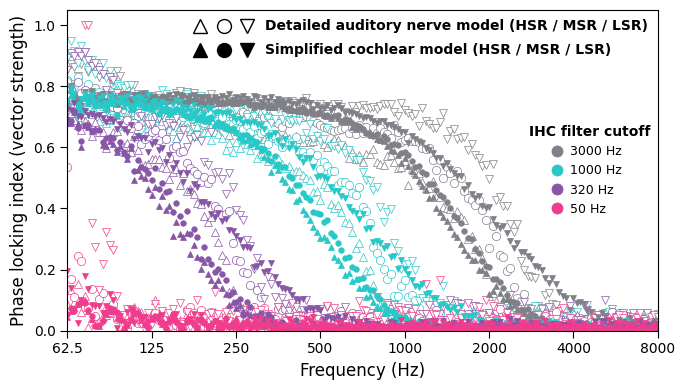

In [19]:
df_to_plot = pd.concat([
    df_bez2018model,
    df,
])
fig, ax = plt.subplots(figsize=(7, 4))
list_spont = [
    'HSR',
    'MSR',
    'LSR',
]
vs_key = 'vs_binomial_approx'
list_tag_model = [
    'bez2018model_ihc3000',
    'bez2018model_ihc1000',
    'bez2018model_ihc0320',
    'bez2018model_ihc0050',
    'simplified_ihc3000',
    'simplified_ihc1000',
    'simplified_ihc0320',
    'simplified_ihc0050',
]
for tag_model in list_tag_model:
    print(tag_model)
    color, label = util.get_color_and_label_from_model_tag(tag_model)
    label = label.replace(' IHC filter', '')
    if '' in tag_model:
        dfp = df_to_plot[np.logical_and.reduce([
            df_to_plot.tag_model == tag_model,
        ])]
        for itr_spont, spont in enumerate(list_spont):
            x = dfp.f.values
            if f'{vs_key}_{spont}' in dfp.columns:
                y = dfp[f'{vs_key}_{spont}'].values
                map_spont_to_marker = {
                    'HSR': '^',
                    'MSR': 'o',
                    'LSR': 'v',
                }
                kwargs_plot = {
                    'ls': '',
                    'mew': 0.5,
                    'marker': map_spont_to_marker[spont],
                    'ms': 4 if 'simplified' in tag_model else 6,
                    'mfc': None if 'simplified_ihc' in tag_model else 'w',
                    'color': color,
                    'label': label if ('simplified' in tag_model and 'MSR' == spont) else None,
                }
                ax.plot(x, y, **kwargs_plot)
xticks = [62.5, 125, 250, 500, 1000, 2000, 4000, 8000]
xticklabels = list(xticks)
util_figures.format_axes(
    ax,
    str_xlabel='Frequency (Hz)',
    str_ylabel='Phase locking index (vector strength)',
    fontweight_title='bold',
    xscale='log',
    yscale='linear',
    fontsize_ticks=10,
    fontsize_labels=12,
    ylimits=[0, 1.05],
    yticks=np.arange(0, 1.01, 0.2),
    xticks=xticks,
    xticklabels=xticklabels,
    xlimits=[62.5, 8e3]
)
ax.minorticks_off()
ax.legend(
    frameon=False,
    framealpha=1,
    edgecolor='k',
    handletextpad=1,
    handlelength=0,
    borderaxespad=0.2,
    markerscale=2,
    fontsize=9,
    ncol=1,
    title='IHC filter cutoff',
    title_fontproperties={'weight': 'bold'},
    loc='center right')
list_y = [0.875, 0.950]
list_x = np.array([0.10, 0.14, 0.18]) + 0.125
list_marker = ['^', 'o', 'v']
for itr_y, y in enumerate(list_y):
    for x, marker in zip(list_x, list_marker):
        kwargs_plot = {
            'marker': marker,
            'ms': 10,
            'color': 'k',
            'mfc': 'w' if itr_y else None,
            'mew': 1,
            'transform': ax.transAxes,
            'zorder': 100,
        }
        ax.plot(x, y, **kwargs_plot)
    if itr_y == 1:
        str_text = 'Detailed auditory nerve model (HSR / MSR / LSR)'
    else:
        str_text = 'Simplified cochlear model (HSR / MSR / LSR)'
    ax.text(x + 0.03, y, str_text, ha='left', va='center', transform=ax.transAxes, fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()
